In [23]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot8Dims_T256_H05_tl_110data_StbleTgt_New  import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [25]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch,  toSave: bool = False):
    rmse = rmse_ignore_nans(true_drift, mean).astype(
        np.float64)  #np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    axes = axes.flatten()  # Flatten to easily index with a single loop
    for d in range(mean.shape[-1]):
        axes[d].scatter(numpy_Xs[:, d], true_drift[:, d], color="red", label="True Drift")
        ymin = mean[:, d] - mean_min[:, d]
        ymax = mean_max[:, d] - mean[:, d]
        ymin[ymin < 0.] = 0.
        ymax[ymax < 0.] = 0.
        axes[d].errorbar(numpy_Xs[:, d], mean[:, d], yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
        axes[d].errorbar(numpy_Xs[:, d], mean[:, d], label="Estimated Drift", color="blue")
        axes[d].set_title(rf"MSE {round(rmse, 6)} for MLP Score Estimator", fontsize=22)
        axes[d].tick_params(labelsize=13)
        axes[d].set_xlabel(f"State $X$ at Dimension {d+1}", fontsize=20)
        axes[d].set_ylabel("Drift Value", fontsize=20)
        axes[d].legend(fontsize=14)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()

In [26]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


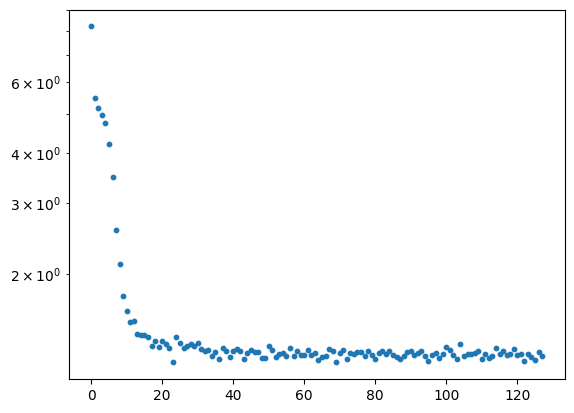

127

In [27]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

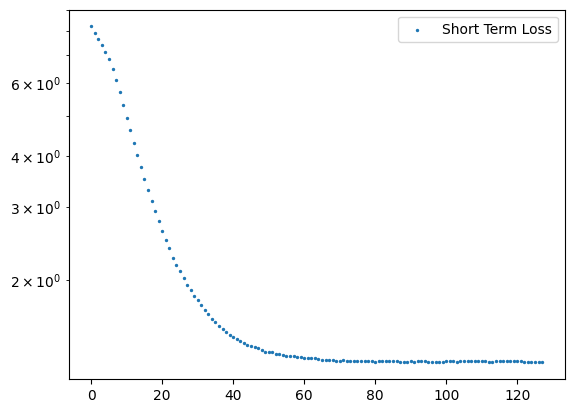

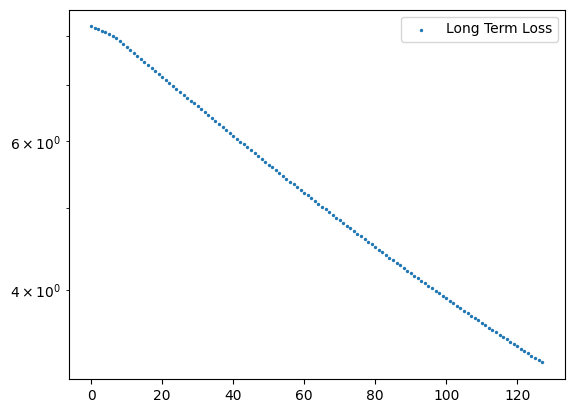

In [28]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

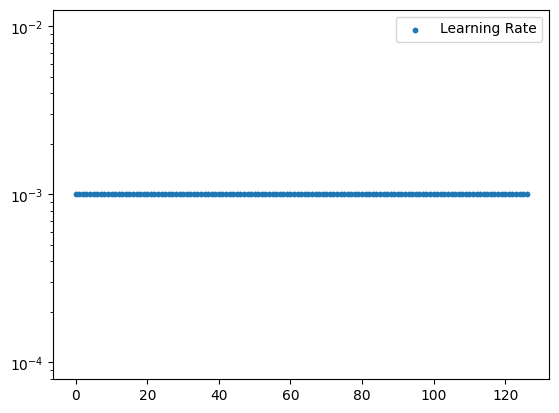

0.001


In [29]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(LRs[-1])

In [30]:
def get_drift_files(config, ts_type):
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/8DDims/NewModel/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "_MLP_" in file and ts_type in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "global" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [32]:
ts_type = f"ST_{config.feat_thresh:.3f}FTh_New_fBiPot_{config.ndims}DDims".replace(".", "")
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config=config, ts_type=ts_type)
len(Nepochs_track)
print(drift_true_files)

['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_ST_0010FTh_New_fBiPot_8DDims_OOSDriftTrack_1Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_ST_0010FTh_New_fBiPot_8DDims_OOSDriftTrack_2Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_ST_0010FTh_New_fBiPot_8DDims_OOSDriftTrack_4Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/T

In [33]:
def get_evalexp_drift_files(ts_type_str):
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/8DDims/NewModel/"
    driftevalexp_files = []
    for file in os.listdir(root_score_dir):
        if "_MLP_" in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file:
                    driftevalexp_files.append(root_score_dir+file)
    assert len(driftevalexp_files)>0, "No eval exp files found"
    def extract_Nepoch_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_Nepoch_drift_eval_exp_number)
    Nepochs_drifteval = [extract_Nepoch_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, Nepochs_drifteval

In [34]:
driftevalexp_files, Nepochs_drifteval = get_evalexp_drift_files(ts_type_str=ts_type)
len(Nepochs_track)
print(drift_true_files)

['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_ST_0010FTh_New_fBiPot_8DDims_OOSDriftTrack_1Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_ST_0010FTh_New_fBiPot_8DDims_OOSDriftTrack_2Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_ST_0010FTh_New_fBiPot_8DDims_OOSDriftTrack_4Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/NewModel/T

In [35]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        print(str(Nepoch), str(Nepoch)[-1])
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        #del all_true_states, all_local_states, all_local_errors, total_local_errors
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

1 1
2 2
4 4
6 6
8 8
10 0
12 2
14 4
16 6
18 8


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_35782/2041196041.py:12: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_35782/2041196041.py:13: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


20 0
22 2
24 4
26 6
28 8
30 0
32 2
34 4
36 6
38 8
40 0
42 2
44 4
46 6
48 8
50 0
52 2
54 4
56 6
58 8
60 0
62 2
64 4
66 6
68 8
70 0
72 2
74 4
76 6
78 8
80 0
82 2
84 4
86 6
88 8
90 0
92 2
94 4
96 6
98 8
100 0
102 2
104 4
106 6
108 8
110 0
112 2
114 4
116 6
118 8
120 0
122 2
124 4


{1: 24.60067056479993,
 2: 24.607751191487274,
 4: 10.642019507564767,
 6: 19.217514801704965,
 8: 21.5196633459974,
 10: 15.329109841244689,
 12: 10.021633949395655,
 14: 11.338726823465736,
 16: 11.376308810568966,
 18: 11.255194686896115,
 20: 10.58450973255007,
 22: 10.630112970442308,
 24: 10.023244796492378,
 26: 10.050706379401564,
 28: 9.881923137728844,
 30: 10.02462494655011,
 32: 9.620783878302873,
 34: 9.275442637736592,
 36: 9.416256721642677,
 38: 9.159120986149981,
 40: 9.027704118086127,
 42: 9.477884110762492,
 44: 9.333294872986388,
 46: 9.263045748416852,
 48: 9.45154301193517,
 50: 9.588797077393009,
 52: 9.656277272296421,
 54: 9.527874292544091,
 56: 10.29456462522297,
 58: 10.054449245938308,
 60: 10.263577830568355,
 62: 10.268522744647733,
 64: 10.685223789880204,
 66: 10.128676386144623,
 68: 10.072666574025938,
 70: 10.399545005980789,
 72: 11.090726819295474,
 74: 10.259576483368146,
 76: 11.238265984474035,
 78: 10.541254595482483,
 80: 11.395322226075127,


In [36]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True)).numpy()
        Xshape = muhats.shape[0]
        Xs = np.concatenate([np.linspace(-4.9, 4.9, num=Xshape).reshape(-1, 1), np.linspace(-4.4, 4.4, num=Xshape).reshape(-1,1), \
                                     np.linspace(-4.05, 4.05, num=Xshape).reshape(-1,1), np.linspace(-3.9, 3.9, num=Xshape).reshape(-1,1), \
                                     np.linspace(-3.7, 3.7, num=Xshape).reshape(-1,1), np.linspace(-3.6, 3.6, num=Xshape).reshape(-1,1), \
                                     np.linspace(-3.5, 3.5, num=Xshape).reshape(-1,1), np.linspace(-3.4, 3.4, num=Xshape).reshape(-1,1)],
                                    axis=1)
        true_drifts = -(4. * np.array(config.quartic_coeff) * np.power(Xs,
                                                                       3) + 2. * np.array(
                config.quad_coeff) * Xs + np.array(config.const))
        mu_hats = muhats[:, -1, :, :].reshape(muhats.shape[0], muhats.shape[2],muhats.shape[-1]*1).mean(axis=1)
        mse = np.nanmean(np.sum((true_drifts-mu_hats)**2, axis=-1))
        eval_exp_rmses.update({Nepoch: round(mse, 6)})
    except pickle.UnpicklingError as e:
        continue
    except FileNotFoundError as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys())).flatten()
eval_exp_rmses

{1: 18584.608158,
 2: 18547.684523,
 4: 15591.879989,
 6: 15283.489771,
 8: 15864.033099,
 10: 18379.74025,
 12: 12682.285881,
 14: 9934.479898,
 16: 8721.060458,
 18: 8049.019331,
 20: 7372.342121,
 22: 6755.496413,
 24: 6839.175364,
 26: 6569.840503,
 28: 6203.240554,
 30: 6437.492748,
 32: 6322.958626,
 34: 6293.35638,
 36: 6064.23679,
 38: 5900.307851,
 40: 6187.422738,
 42: 5908.187187,
 44: 5933.453937,
 46: 5860.101901,
 48: 5651.064182,
 50: 5710.301242,
 52: 5529.336264,
 54: 5495.188788,
 56: 5231.966244,
 58: 5367.915897,
 60: 5190.876632,
 62: 5121.014479,
 64: 5072.460195,
 66: 5175.089603,
 68: 4898.036968,
 70: 4956.522634,
 72: 4876.357899,
 74: 4849.623712,
 76: 4704.944765,
 78: 4807.251378,
 80: 4906.184683,
 82: 4569.129173,
 84: 4581.99815,
 86: 4561.721909,
 88: 4623.752201,
 90: 4493.644525,
 92: 4380.0374,
 94: 4367.822764,
 96: 4590.195597,
 98: 4354.456161,
 100: 4460.639549,
 102: 4328.621928,
 104: 4451.698607,
 106: 4388.867025,
 108: 4384.187068,
 110: 429

In [37]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])
print(Nepochs_losses)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]


In [38]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
print(Nepochs_losses)
common_epochs = np.intersect1d(common_epochs, np.arange(40, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
print(common_epochs)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
[ 40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74
  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110
 112 114 116 118 120 122 124]


In [39]:
common_epochs = np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_drifteval), Nepochs_track)
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

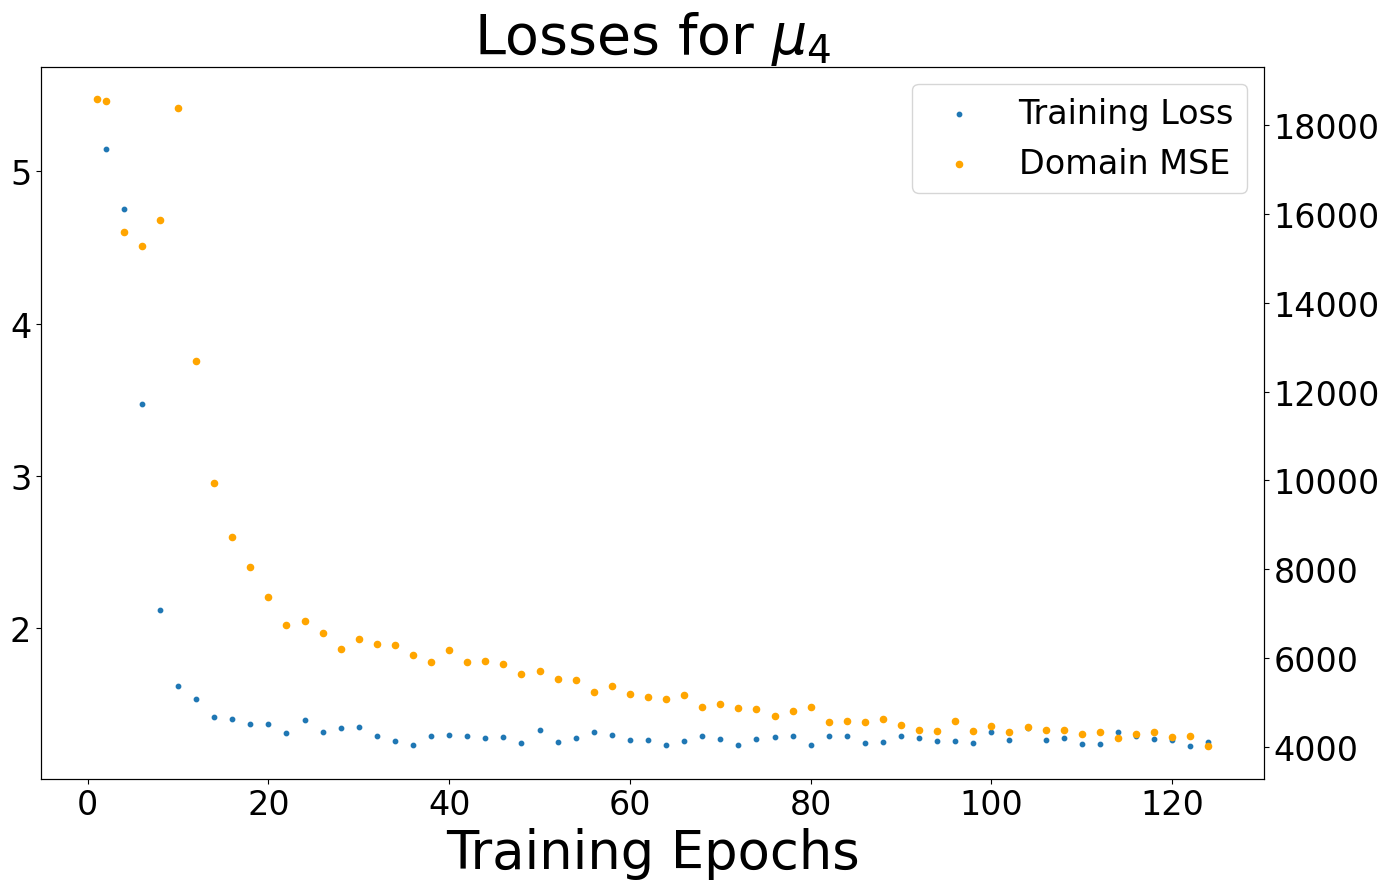

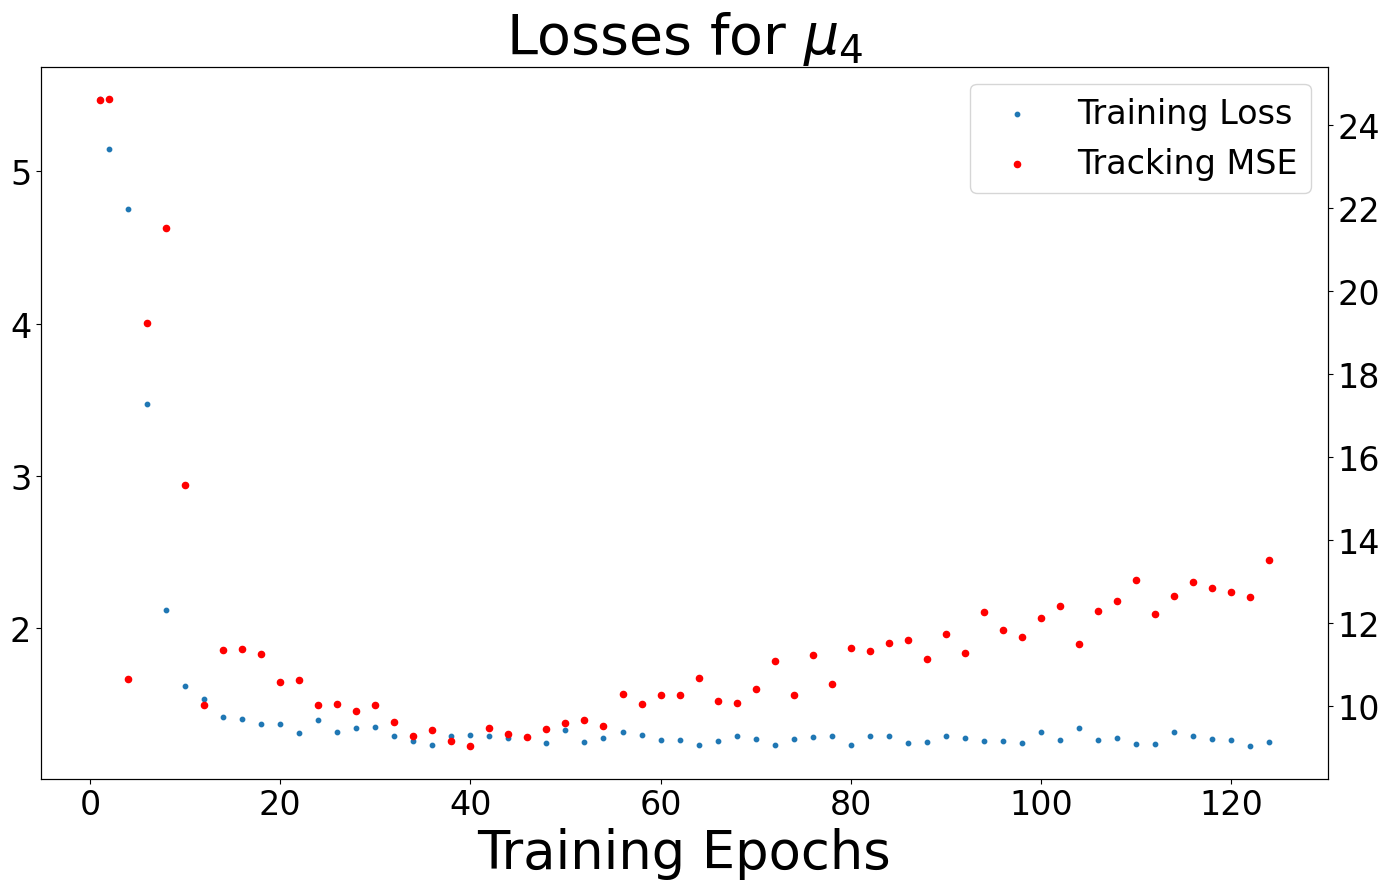

In [40]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{4}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{4}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

(256, 8) (256, 8)


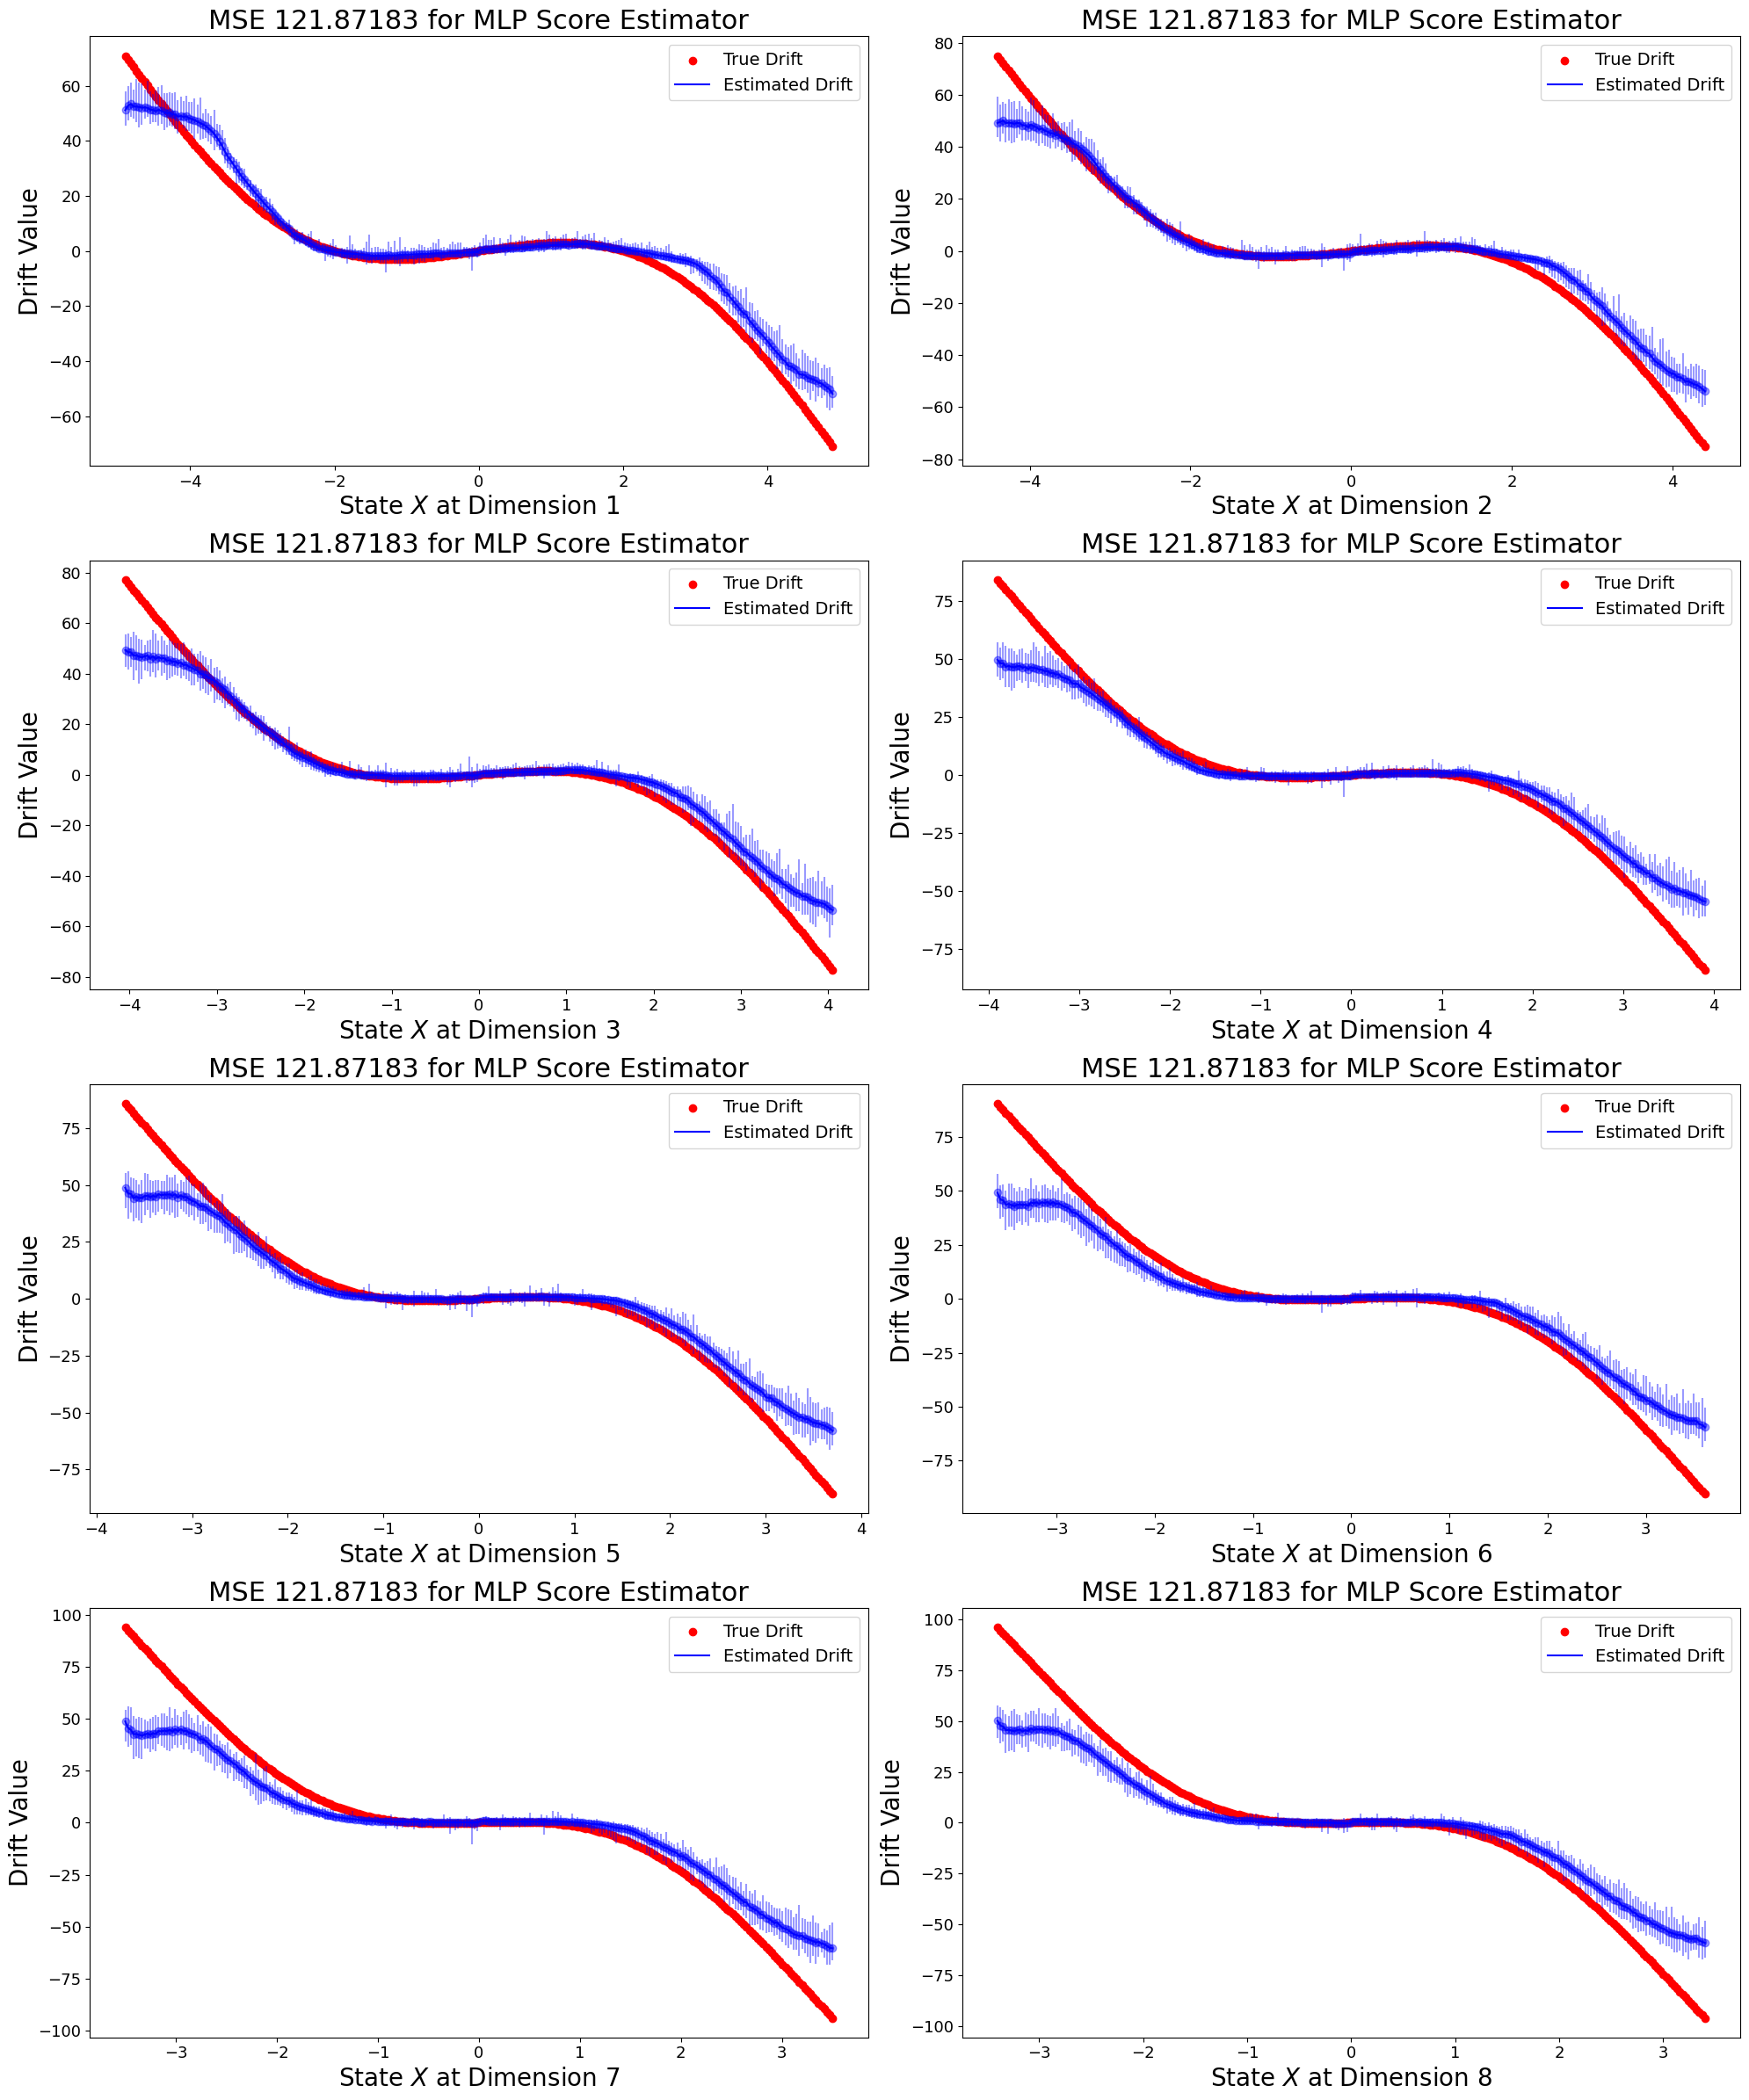

MSE  974.9746370438255 ay Nepoch 100

(256, 8) (256, 8)


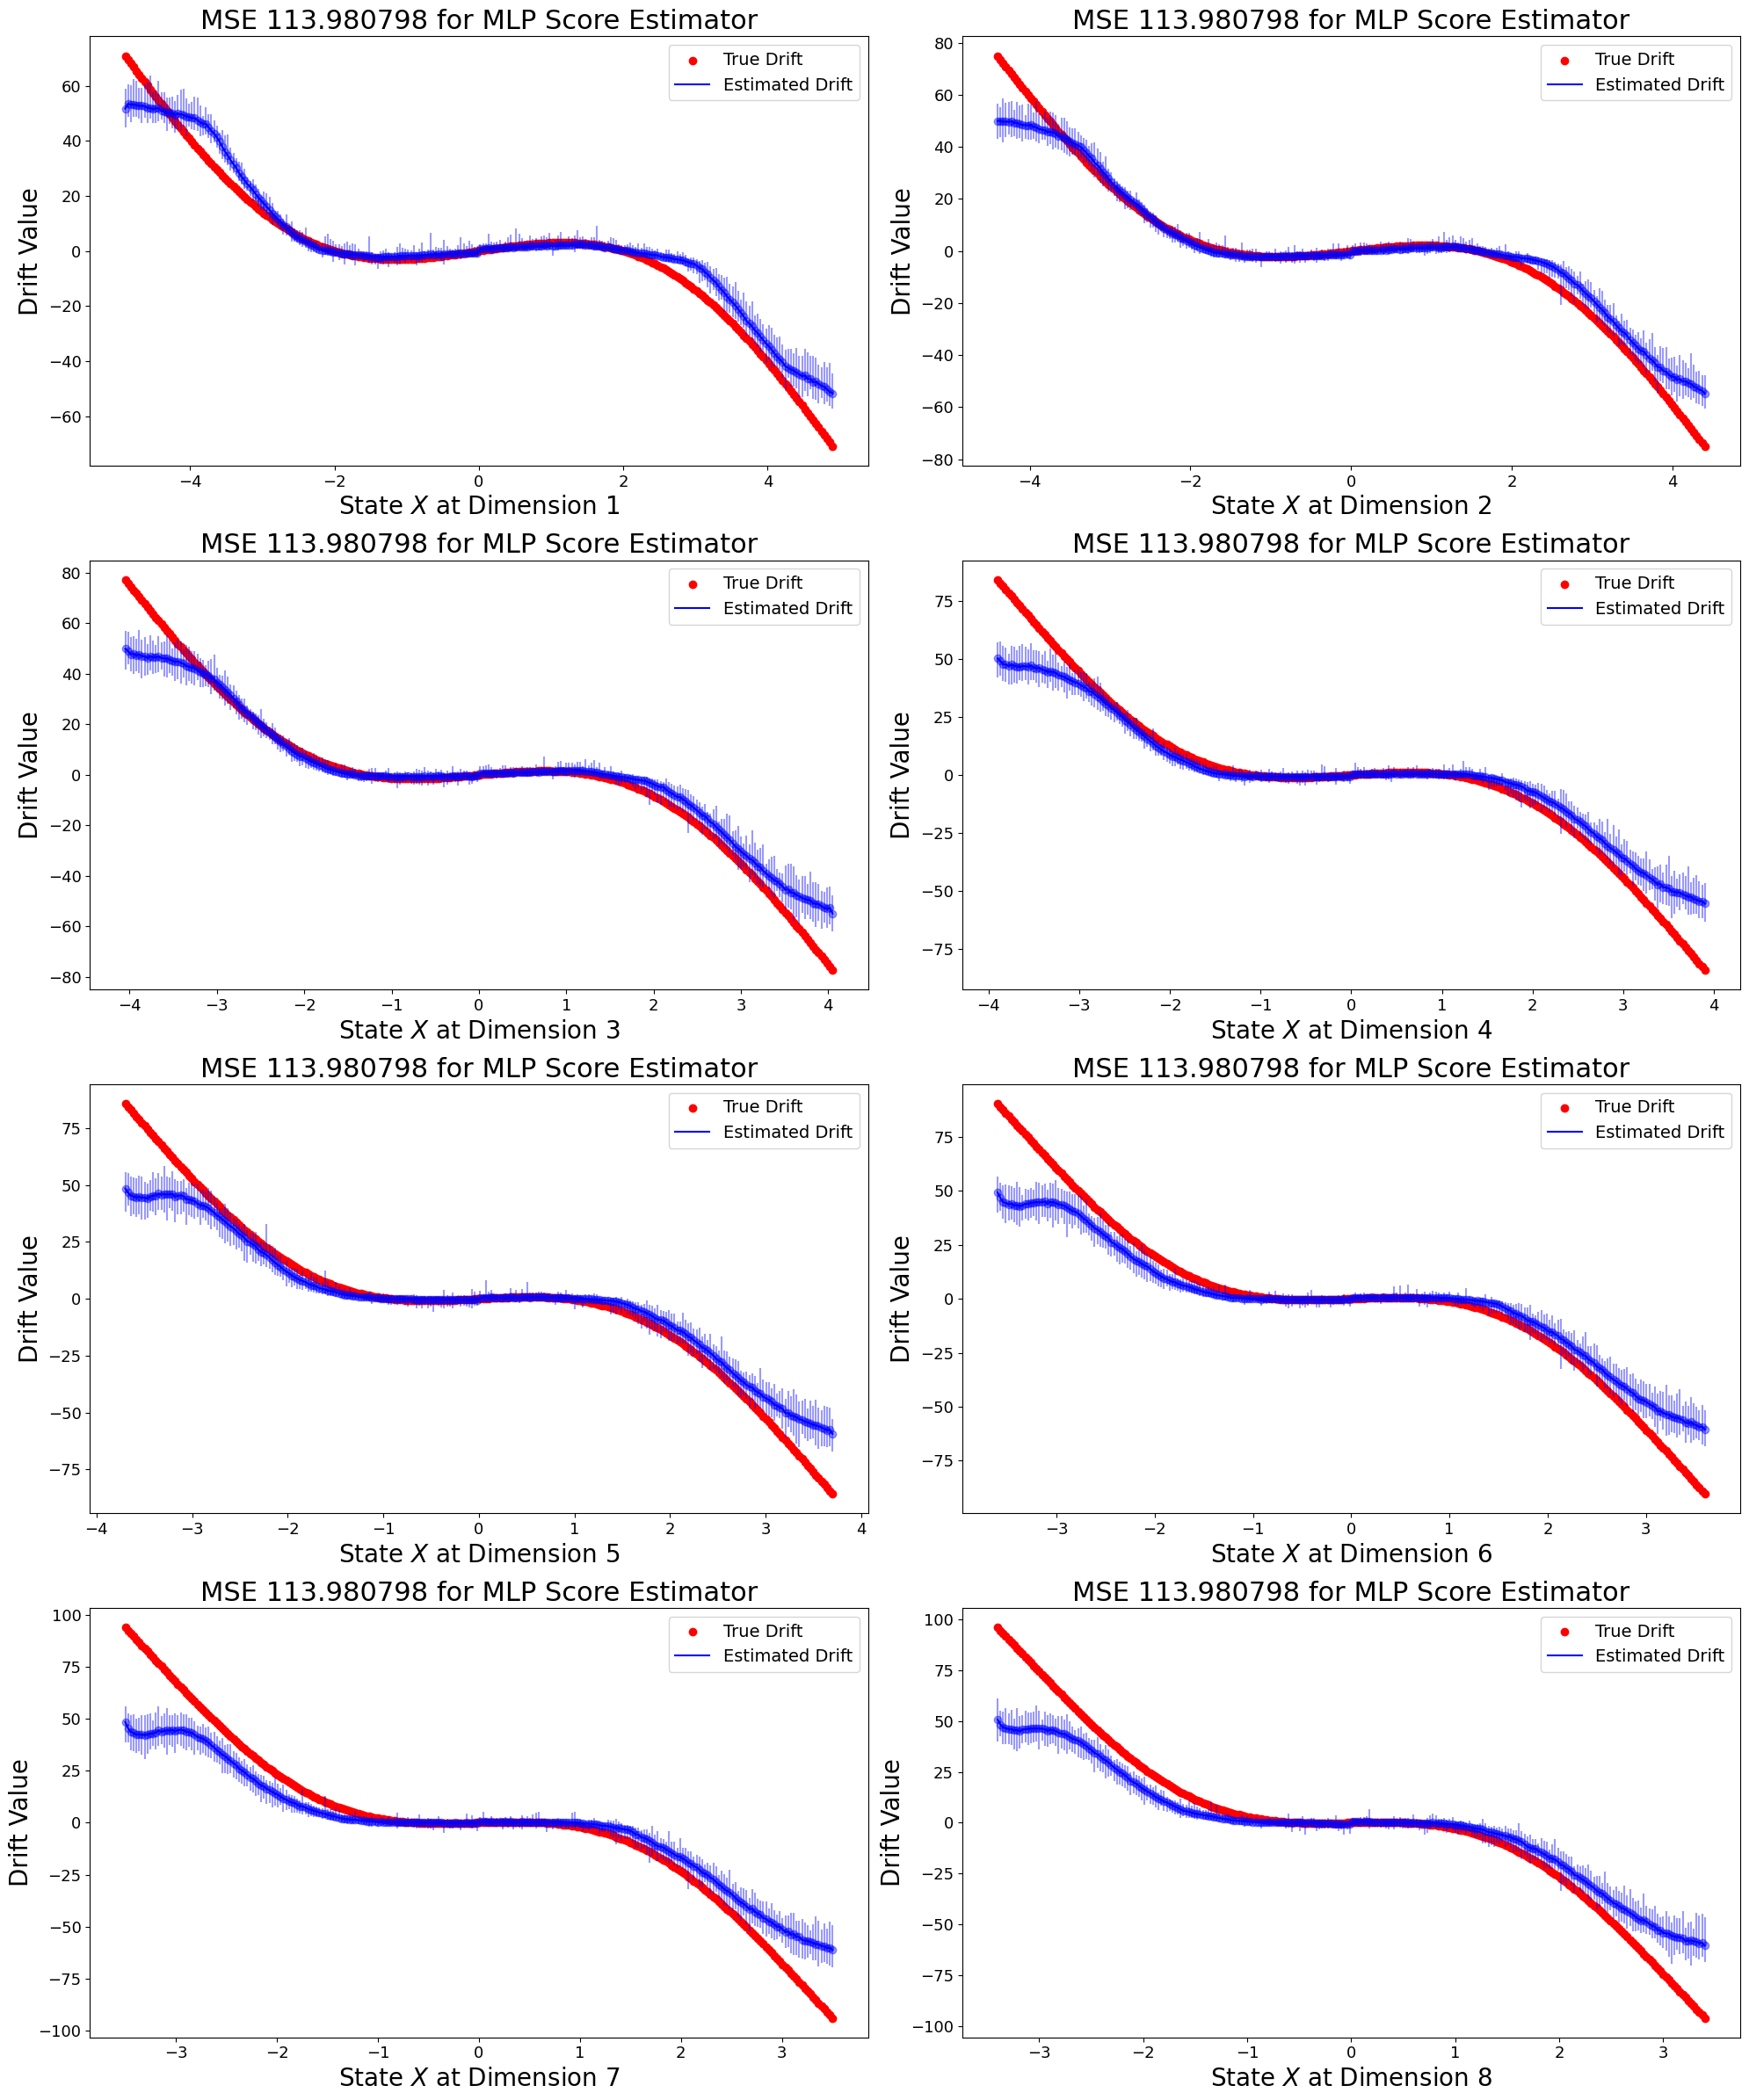

MSE  911.8463860226664 ay Nepoch 102

(256, 8) (256, 8)
(256, 8) (256, 8)
(256, 8) (256, 8)
(256, 8) (256, 8)


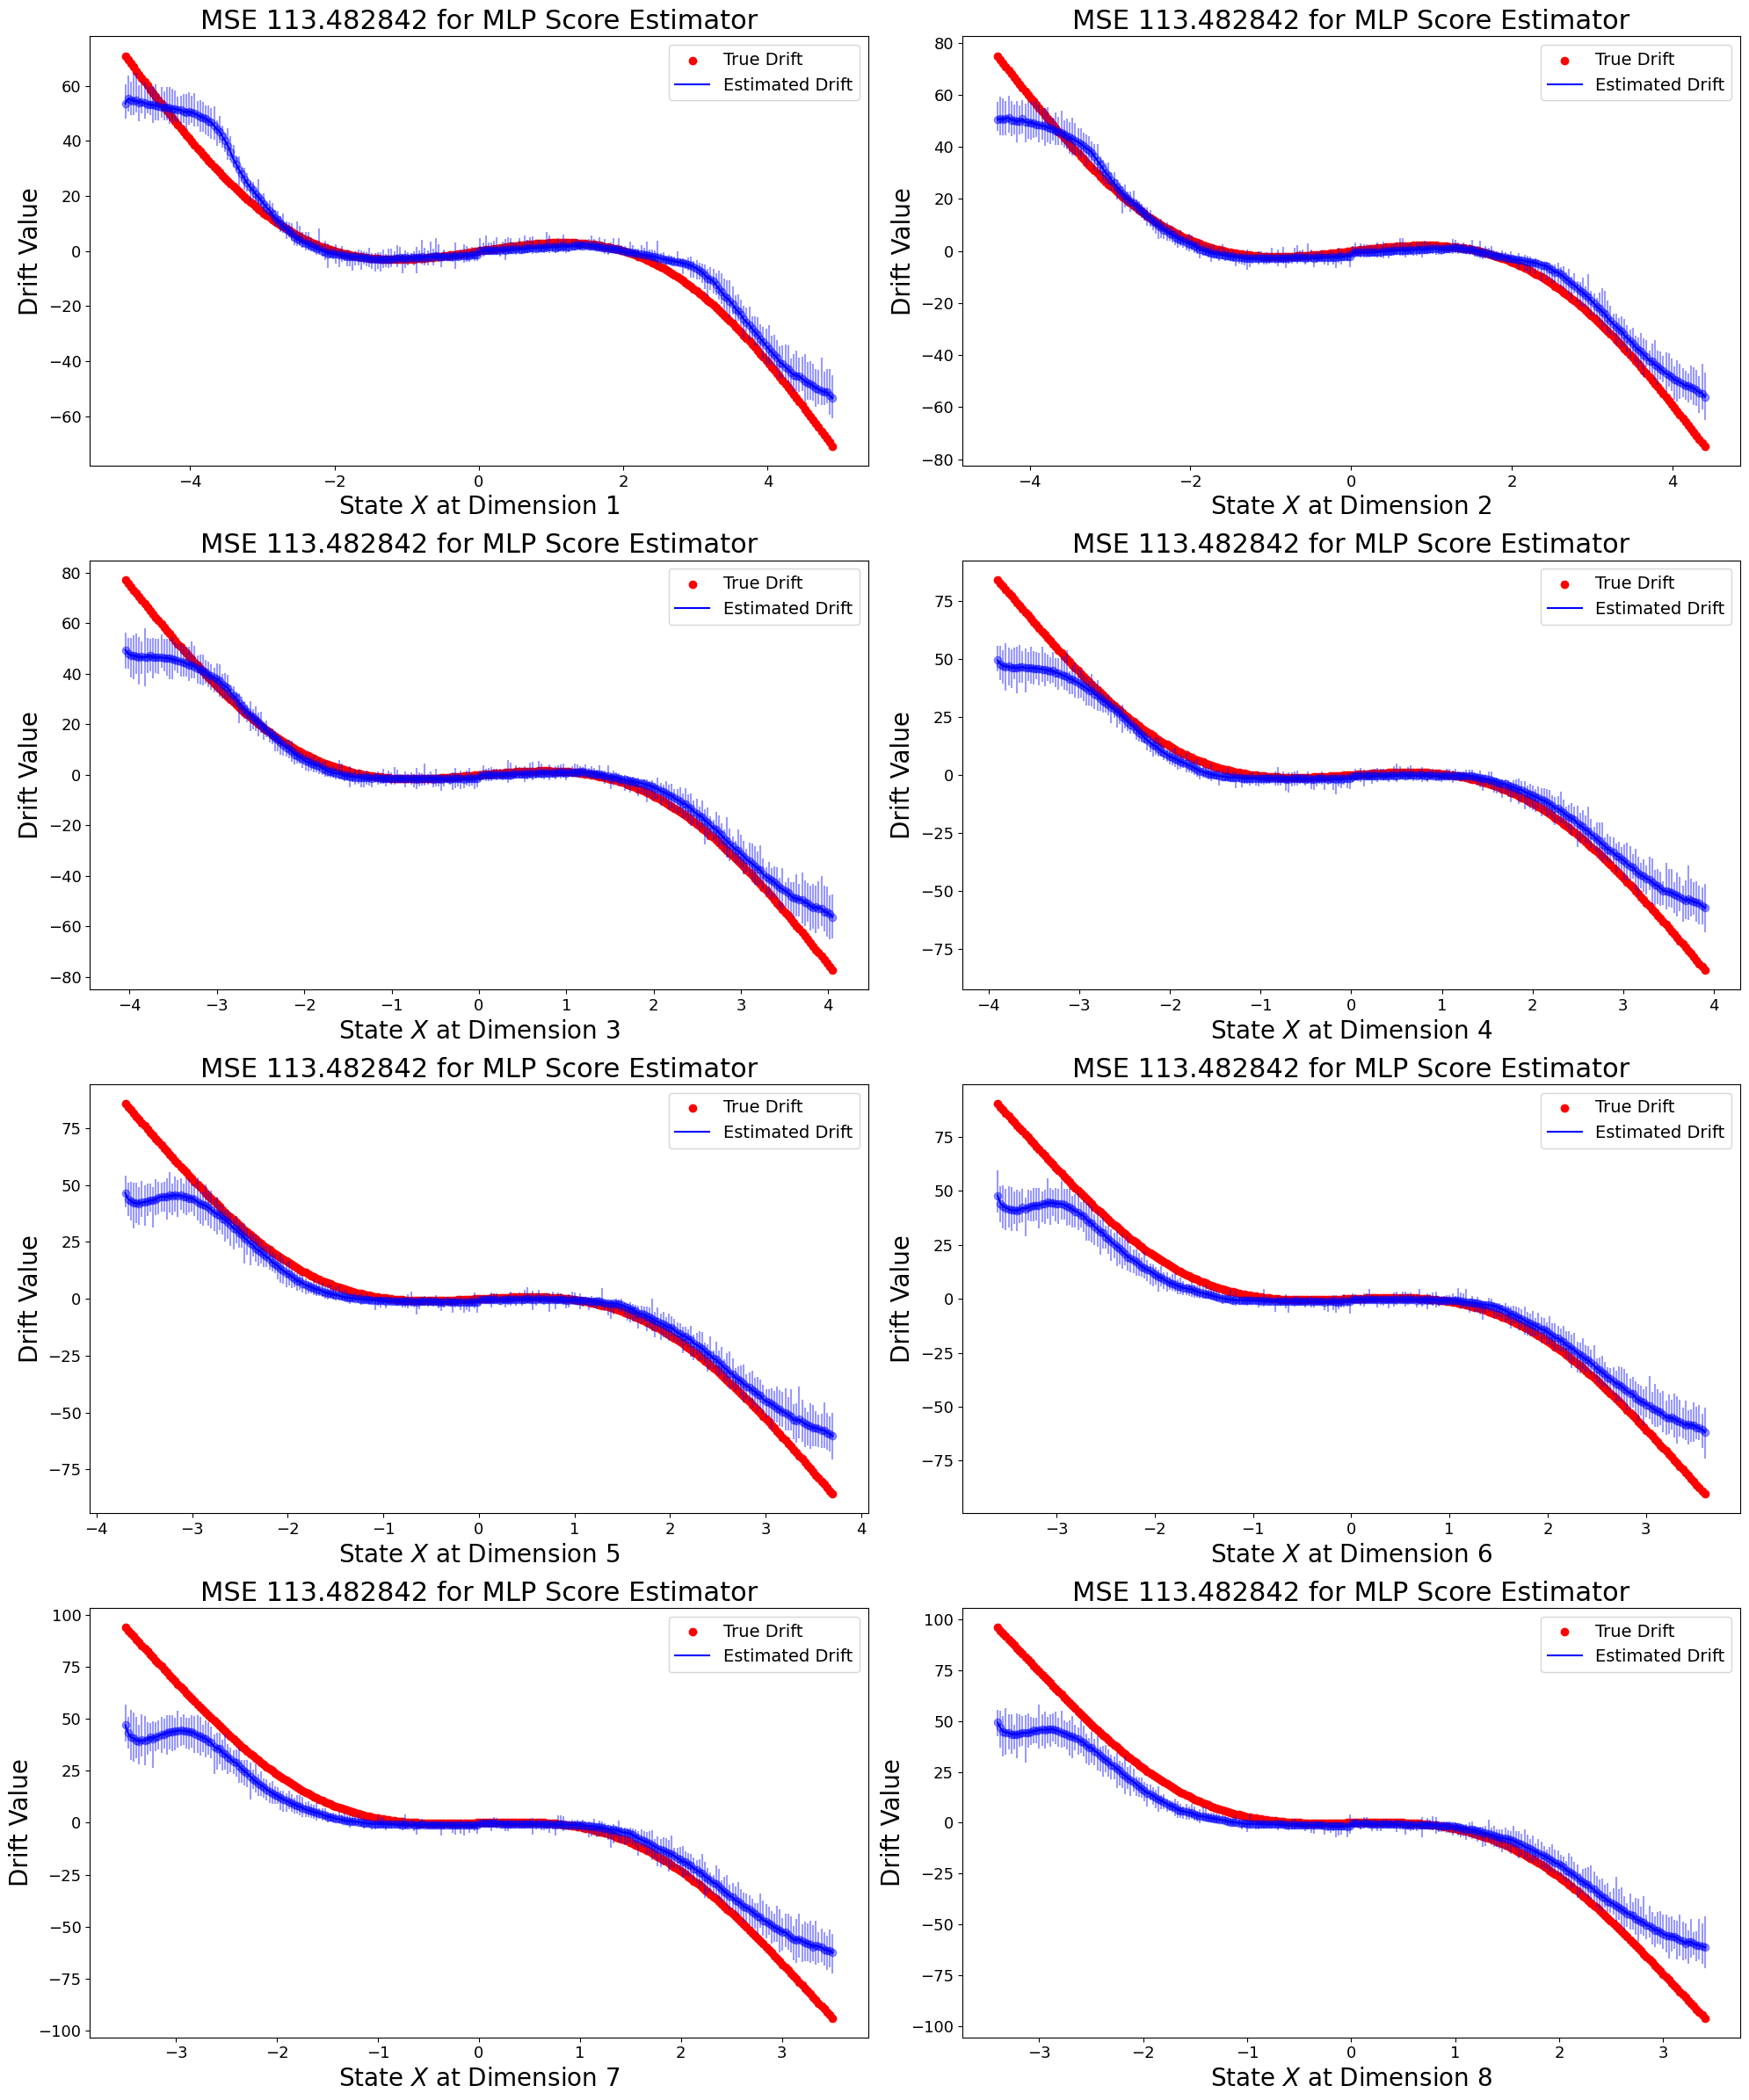

MSE  907.8627364450427 ay Nepoch 110

(256, 8) (256, 8)
(256, 8) (256, 8)


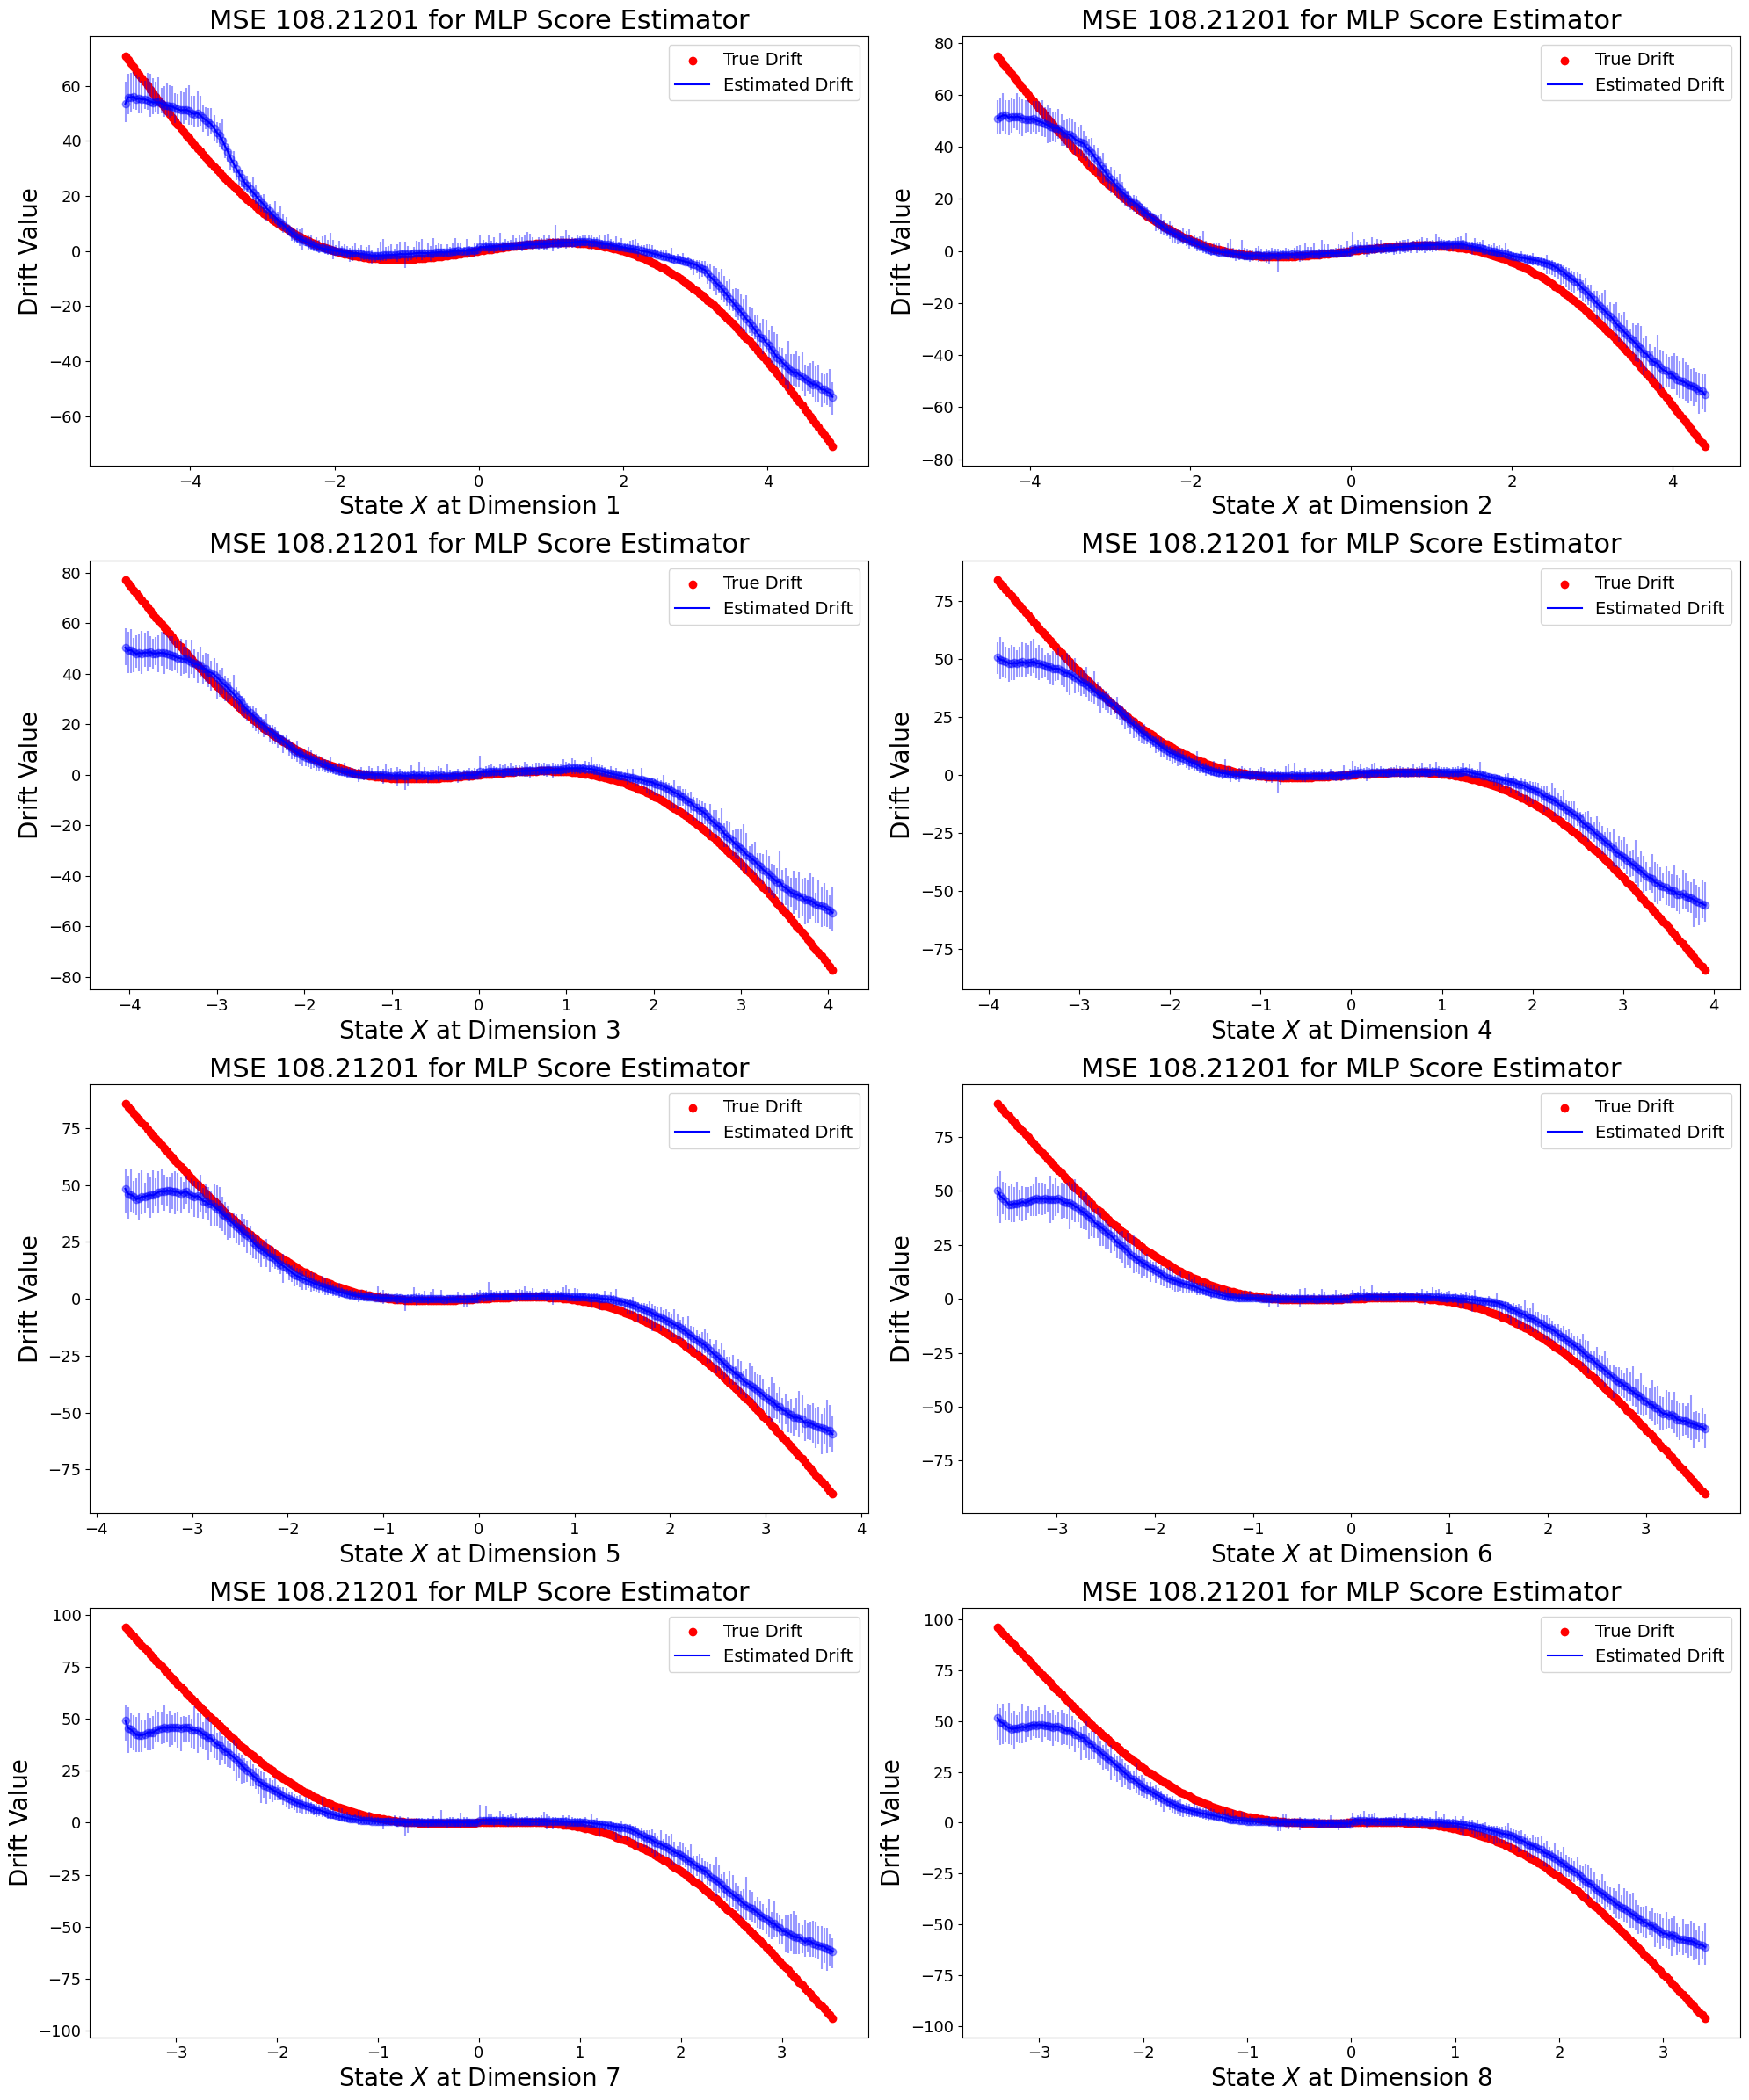

MSE  865.6960823311325 ay Nepoch 114

(256, 8) (256, 8)
(256, 8) (256, 8)
(256, 8) (256, 8)
(256, 8) (256, 8)
(256, 8) (256, 8)


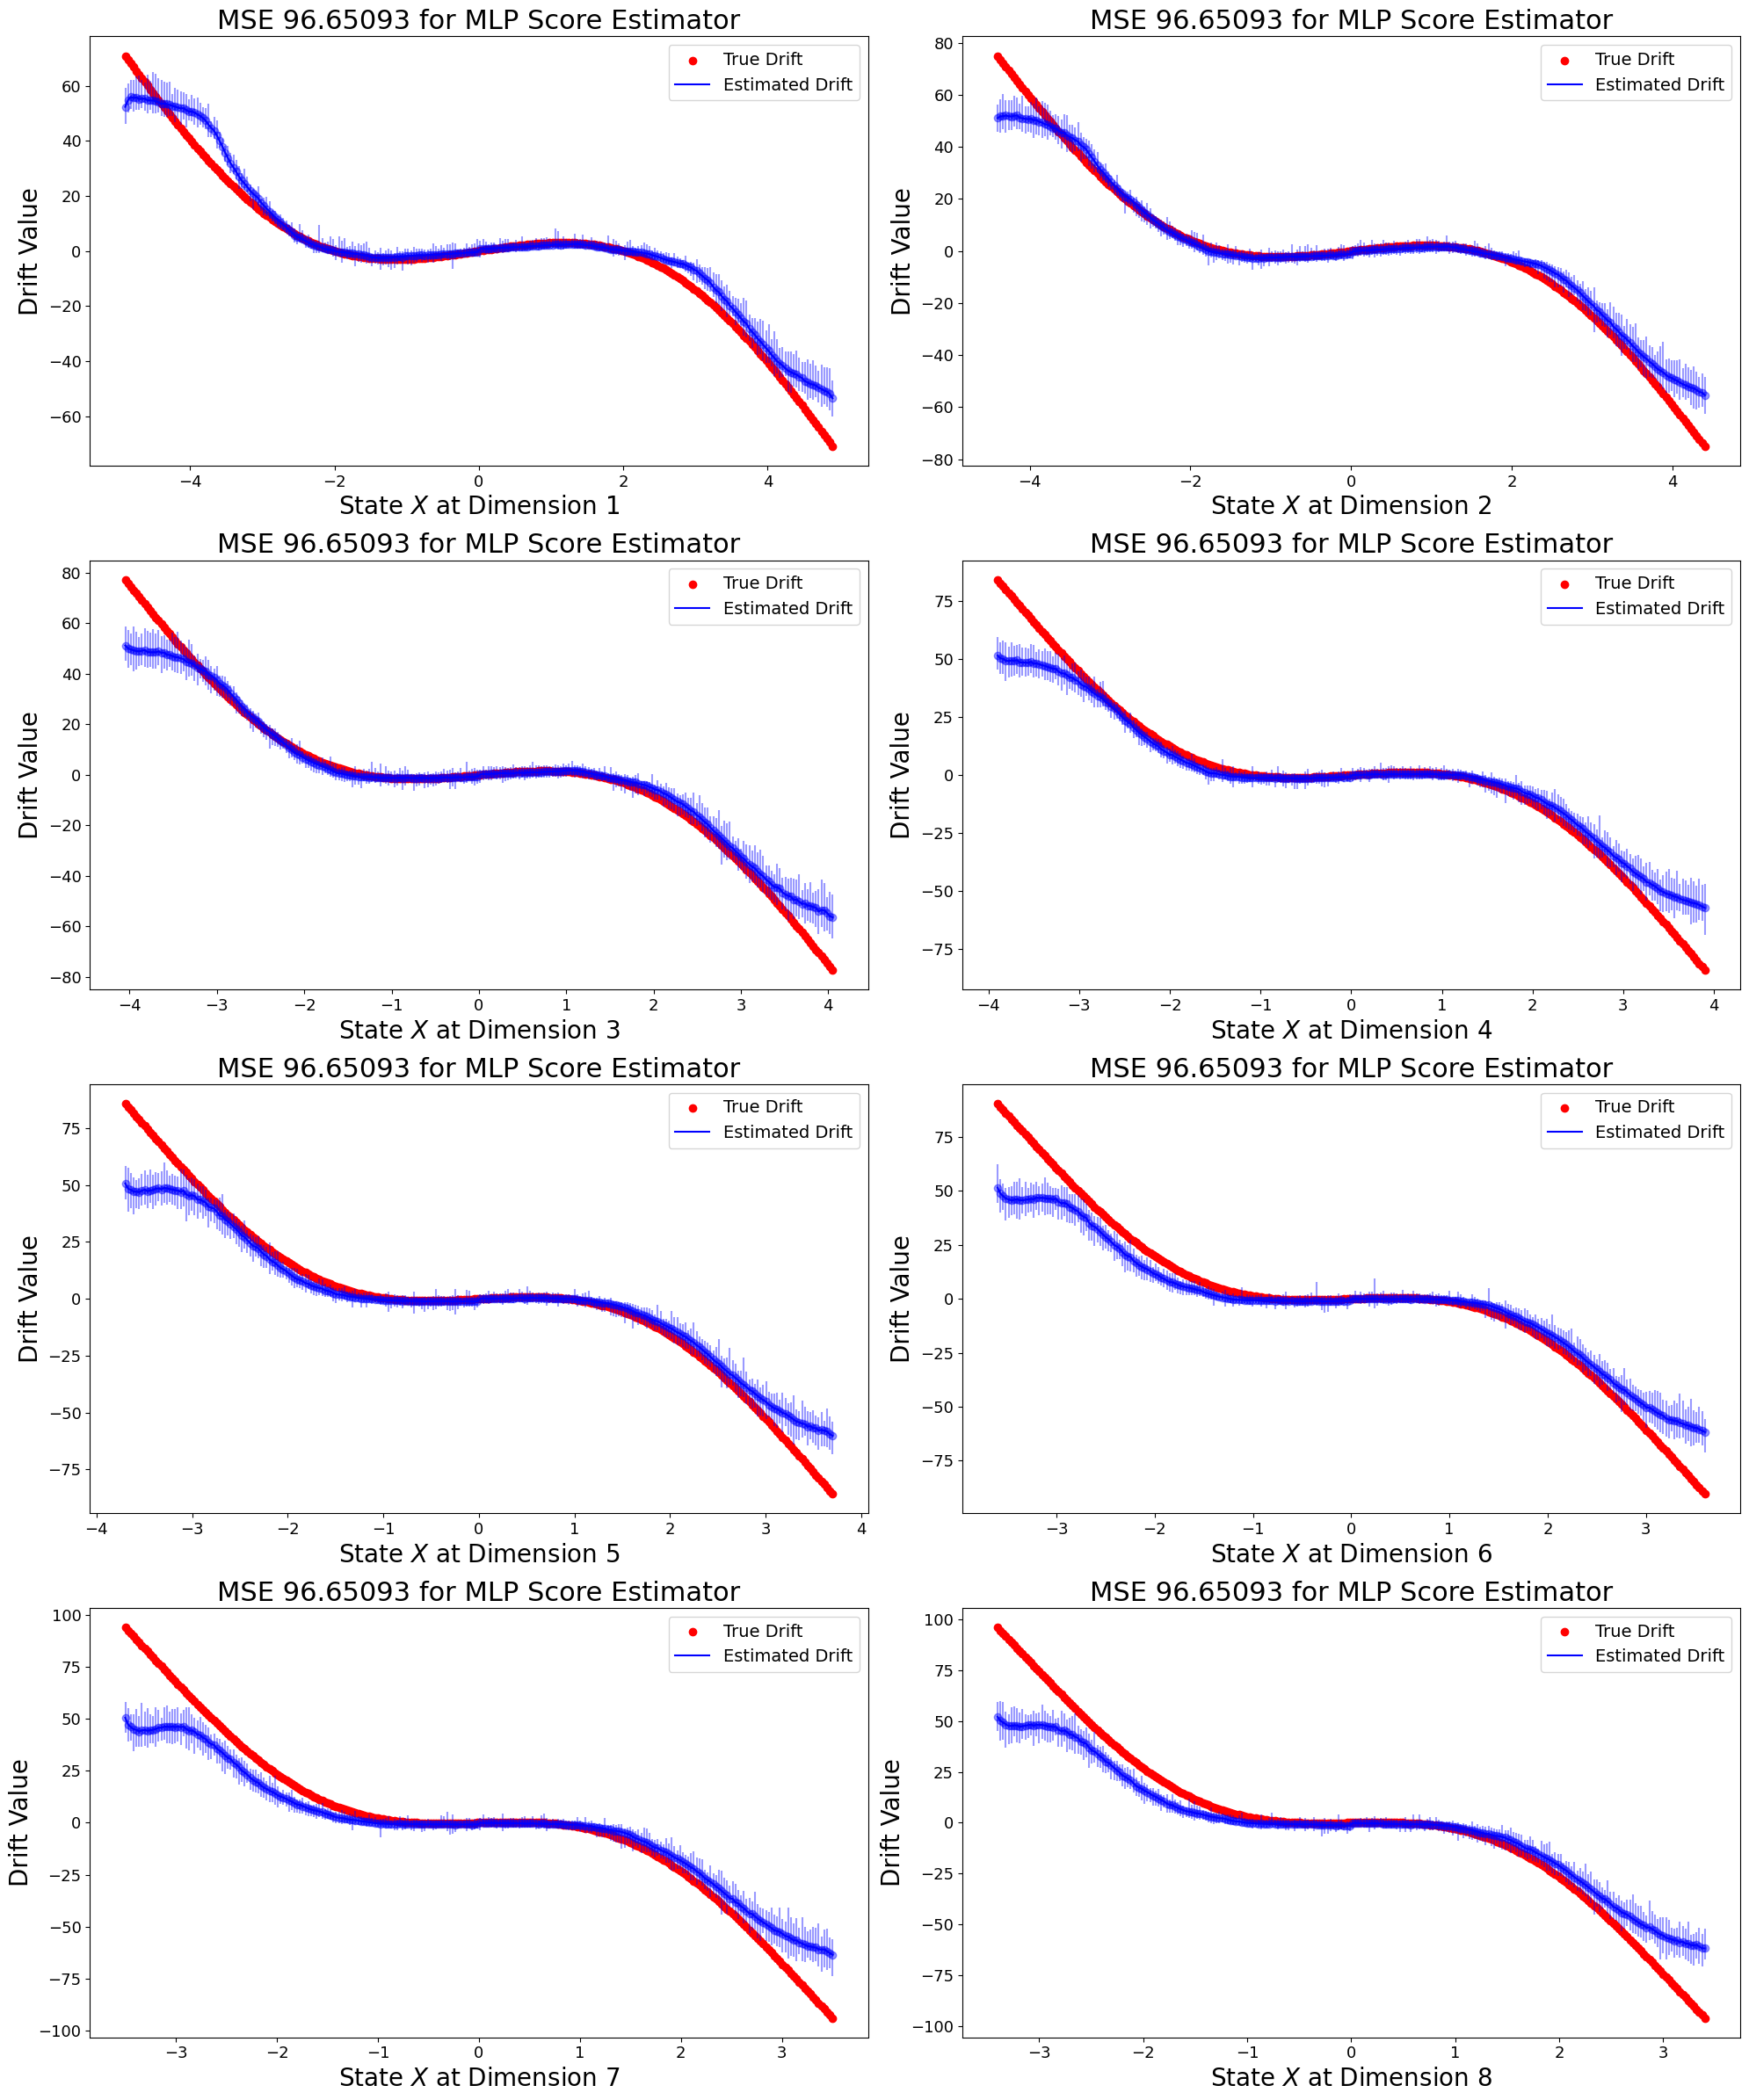

MSE  773.2074379652772 ay Nepoch 124



In [42]:
curr_best_mse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    try:
        if Nepoch < 100: raise FileNotFoundError
        ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
        file = driftevalexp_files[ff_idx]
        muhats = torch.Tensor(np.load(file, allow_pickle=True)).numpy()
        Xshape = muhats.shape[0]
        Xs = np.concatenate([np.linspace(-4.9, 4.9, num=Xshape).reshape(-1, 1), np.linspace(-4.4, 4.4, num=Xshape).reshape(-1,1), \
                                     np.linspace(-4.05, 4.05, num=Xshape).reshape(-1,1), np.linspace(-3.9, 3.9, num=Xshape).reshape(-1,1), \
                                     np.linspace(-3.7, 3.7, num=Xshape).reshape(-1,1), np.linspace(-3.6, 3.6, num=Xshape).reshape(-1,1), \
                                     np.linspace(-3.5, 3.5, num=Xshape).reshape(-1,1), np.linspace(-3.4, 3.4, num=Xshape).reshape(-1,1)],
                                    axis=1)
        true_drifts = -(4. * np.array(config.quartic_coeff) * np.power(Xs,
                                                                       3) + 2. * np.array(
                config.quad_coeff) * Xs + np.array(config.const))
        true_drifts = true_drifts/(1.+config.deltaT*np.abs(true_drifts))

        muhats = muhats[:, -1, :, :].reshape(muhats.shape[0], muhats.shape[2],muhats.shape[-1]*1)
        mu_hats = muhats.mean(axis=1)
        print(mu_hats.shape, true_drifts.shape)
        mse = np.nanmean(np.sum((true_drifts-mu_hats)**2, axis=-1))
        if mse < curr_best_mse:
            mu_hats_minq = np.quantile(muhats, q=0.005, axis=1) # Lower bound
            mu_hats_maxq = np.quantile(muhats, q=0.995, axis=1) # uPPER bound
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, numpy_Xs=Xs, true_drift=true_drifts, Nepoch=Nepoch, toSave=toSave)
            curr_best_mse = mse
            print(f"MSE  {mse} ay Nepoch {Nepoch}\n")
    except FileNotFoundError:
        continue

In [ ]:
curr_rmse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        if Nepoch < 50: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        print(all_local_states.shape)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_4$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/8DDims/NewModel/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue